<h1>CV Project: Lidar Clustering</h1>

# Description
We are given a set of Lidar and RGB images images, we are formally asked to segment the cluster of lidar.

# Import, load repo and set seeds

In [1]:
import numpy as np
import torch
import cv2
import pytorch_lightning as pl
from glob import glob
from torch import nn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from easydict import EasyDict

In [2]:
# Set seeds
torch.manual_seed(420)
np.random.seed(420)

In [3]:
# Define Constants
IMG_SHAPE = (320, 1216)
 # After resizing

# Data Visualization

In [4]:
from utils.dataloader.labels import *

In [5]:
NR_CLASSES = len(set([x.trainId for x in labels])) # default class
print(NR_CLASSES)

4


In [6]:
def show(data, label):
    """ Function to show"""
    batch = len(data["left_rgb"].shape) == 4
    
    data = EasyDict(data)
    # Handle batches by plotting only first element
    
    if batch:
        left_rgb_np = data.left_rgb[0].numpy().transpose(1, 2, 0)
        left_sd_np = data.left_sdisp[0].numpy()[0]
        left_d_np = data.left_disp[0].numpy()[0]
        # DO NOT MAP SINCE EXPECT TO BE ALREADY IN ONE HOT ENCODING
        left_segm_np = label[0]

        # Shuffle color
        left_segm_np = (label[0]*30 + 20)%256
    else:
        left_rgb_np = data.left_rgb.numpy().transpose(1, 2, 0)
        left_sd_np = data.left_sdisp.numpy()[0]
        left_d_np = data.left_disp.numpy()[0]
        # Map Label to OneHotEncoding


        # Shuffle color
        left_segm_np = (label*30 + 20)%256

    # Map label back to color
    visualize_rgb = True
    visualize_sd = True
    visualize_d = True
    visualize_segm = True

    # Visualization
    if visualize_rgb:
        _, axes = plt.subplots()
        axes.set_title('RGB (left)')
        axes.imshow(left_rgb_np)
    if visualize_sd:
        _, axes = plt.subplots()
        axes.set_title('LiDAR (left)')
        axes.imshow(left_sd_np)
    if visualize_d:
        _, axes = plt.subplots()
        axes.set_title('Depth (left)')
        # No sample on this
        axes.imshow(left_d_np)
    if visualize_segm:
        _, axes = plt.subplots()
        axes.set_title('Segmentation (left)')
        axes.imshow(left_segm_np, cmap="viridis")
    plt.show(block=False)

# Training Preparation

In [7]:
BATCH_SIZE = 2
EPOCHS = 5

In [8]:
from utils.dataloader.dataset import DatasetKITTI2015

dataset = DatasetKITTI2015(root_dir='./dataset/',
                               mode='training',
                               output_size=IMG_SHAPE,
                               random_sampling=0.15) # Of Lidar Points

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


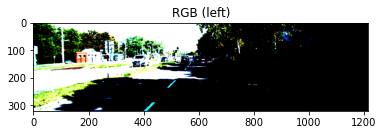

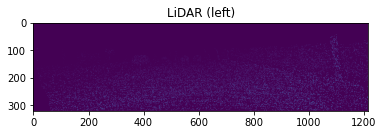

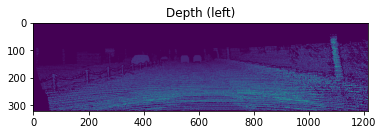

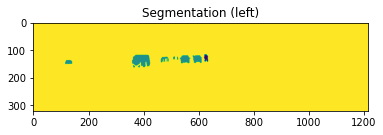

In [9]:
sample_nr = 30
show(dataset[sample_nr][0], dataset[sample_nr][1])


In [10]:
NR_SAMPLES = len(dataset)

In [11]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [29]:
from torchvision.models import efficientnet_v2_s
from sklearn.metrics import accuracy_score
from models.convnet import ConvNet
from models.modeltolightning import LightningModel
import segmentation_models_pytorch as smp
from torchmetrics import JaccardIndex
from segmentation_models_pytorch.losses import DiceLoss
# Import the models and the necessary loss
metric = JaccardIndex(task="multiclass", num_classes=NR_CLASSES, ignore_index=4)
loss_fct = DiceLoss('multiclass', ignore_index=4)
unet = smp.UnetPlusPlus(encoder_name='resnet50', encoder_depth=5, encoder_weights='imagenet', decoder_use_batchnorm=True, decoder_channels=(256, 128, 64, 32, 16), decoder_attention_type=None, in_channels=3, classes=NR_CLASSES, activation=None)
model = LightningModel(unet, loss=loss_fct, eval_metric=metric, mode="RGB", optimizer=torch.optim.Adam, lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ggil/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
 10%|▉         | 9.31M/97.8M [00:02<00:28, 3.27MB/s]


KeyboardInterrupt: 

In [28]:
# Test model on one sample
for x, y in train_loader:
    data = x["left_rgb"]
    dict = {x.color:((x.trainId)) for x in labels}
    out = model(data)
    loss = loss_fct(out, y)
    pred = torch.argmax(out, 1)
    acc = metric(pred.squeeze(), y.squeeze())
    print(loss)
    print(acc)
    break

torch.Size([2, 4, 320, 1216])
torch.Size([2, 4, 320, 1216])
tensor(0.1654, grad_fn=<MeanBackward0>)
tensor(0.0438)


# Training Loop

In [30]:
# Wandb config
import wandb
wandb.init()


modes = [[3, 'RGB'],[1, "Lidar"] , [4, "LidarRGB"]] # 'RGB' "Lidar", "LidarRGB"
encoders = ["resnet50", "mit_b2"]
pretrained = ["imagenet", None]

for enc_name in encoders:
    for train in pretrained: 
        for mode in modes:
            wandb_logger = WandbLogger(project="Lidar_Segmentation", name='Unetplusplus' + enc_name + mode[1] + str(train), log_model="all")
            unet = smp.UnetPlusPlus(encoder_name=enc_name, encoder_depth=5, encoder_weights=train, decoder_use_batchnorm=True, decoder_channels=(256, 128, 64, 32, 16), decoder_attention_type=None, in_channels=mode[0], classes=NR_CLASSES, activation=None)
            model = LightningModel(unet, loss=loss_fct, eval_metric=metric, mode=mode[1], optimizer=torch.optim.Adam, lr=1e-4)
            # Save the Model
            wandb.finish()
            torch.save(model.state_dict(), 'weights/Unetplusplus' + enc_name + mode[1] + str(train) + ".pt")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: strozzivirgilio (fiblouis-). Use `wandb login --relogin` to force relogin


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ggil/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
 23%|██▎       | 22.9M/97.8M [00:09<00:30, 2.55MB/s]


KeyboardInterrupt: 

In [19]:
trainer = pl.Trainer(accelerator="cpu", max_epochs=2, logger=wandb_logger)
wandb_logger.watch(model)
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: strozzivirgilio (fiblouis-). Use `wandb login --relogin` to force relogin



  | Name        | Type                   | Params
-------------------------------------------------------
0 | model       | Unet                   | 24.4 M
1 | loss        | DiceLoss               | 0     
2 | eval_metric | MulticlassJaccardIndex | 0     
-------------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.747    Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

/home/ggil/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
Thread SenderThread:
Traceback (most recent call last):
  File "/home/ggil/.local/lib/python3.10/site-packages/wandb/sdk/internal/internal_util.py", line 49, in run
    self._run()
  File "/home/ggil/.local/lib/python3.10/site-packages/wandb/sdk/internal/internal_util.py", line 100, in _run
    self._process(record)
  File "/home/ggil/.local/lib/python3.10/site-packages/wandb/sdk/internal/internal.py", line 328, in _process
    self._sm.send(record)
  File "/home/ggil/.local/lib/python3.10/site-packages/wandb/sdk/internal/sender.py", line 387, in send
    send_handler(record)
  File "/home/ggil/.local/lib/python3.10/site-packages/wandb/sdk/internal/sender.py", line 589, in send_exit
    self._update_summary()
  File "/home/ggil/.local/lib/python3.10/site-packages/wandb/sdk/internal/sender.py", line 1162, in _update_summary
    with open(summar

# Save Model

In [18]:
# Save the Model
torch.save(model.state_dict(), 'weights/unetweights.pt')

In [19]:
model.load_state_dict(torch.load("weights/unetweights.pt"))

<All keys matched successfully>

# Inference

tensor(0.4458)
tensor(0.0106)


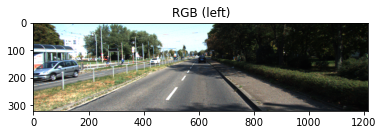

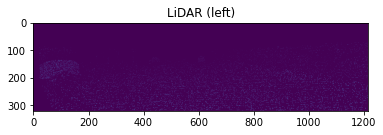

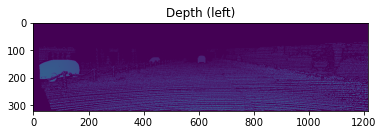

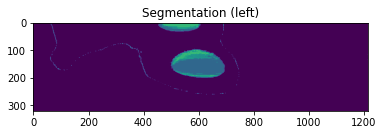

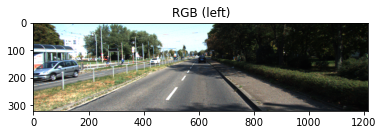

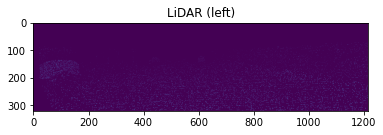

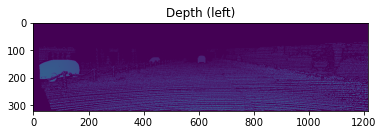

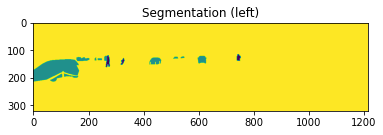

tensor(0.4508)
tensor(0.0078)


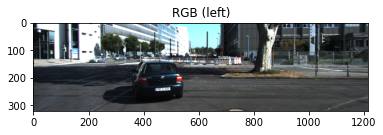

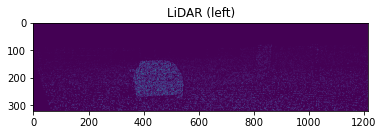

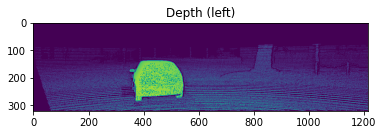

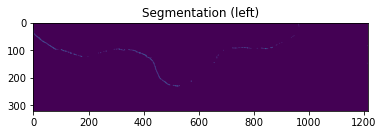

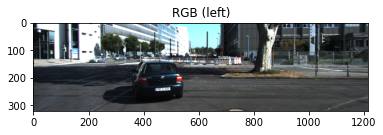

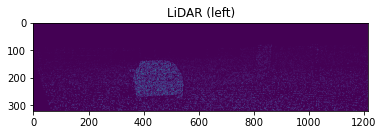

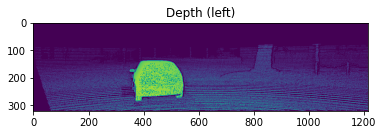

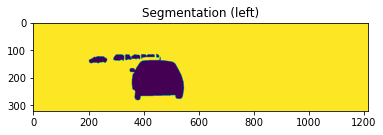

tensor(0.4514)
tensor(0.0005)


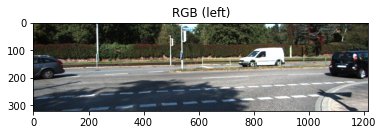

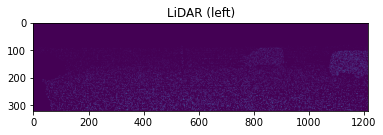

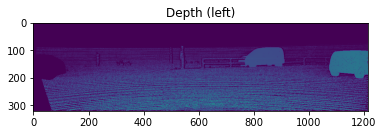

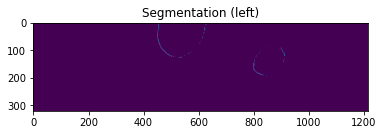

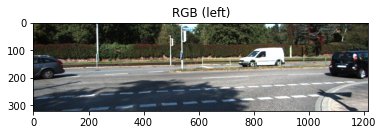

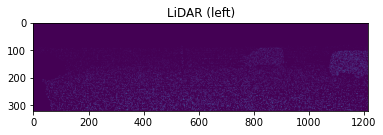

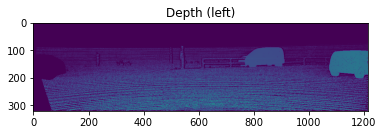

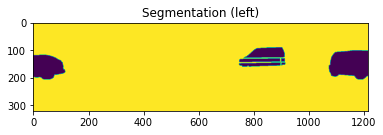

In [33]:
# Test model on one sample
plot_idx = 30
i = 0
model.eval()
with torch.no_grad():
    for x, y in train_loader:
        data = x["left_rgb"]
        dict = {x.color:((x.trainId)) for x in labels}
        label = torch.tensor(list(map(lambda y: RGBtoOneHot(y, dict).astype(int), y)))
        out = model(data)
        loss = loss_fct(out, label)
        pred = torch.argmax(out, 1)
        
        acc = metric(pred.squeeze(), label.squeeze())
        if i % plot_idx  == 5:
            print(loss)
            print(acc)
            show(x, pred)
            show(x, label)
        i+=1

# Inference

# Postprocessing